<a href="https://colab.research.google.com/github/Meralbalik/Capstone-Project-2/blob/master/GANs_Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN For Detecting Pneumonia From X-Ray Images

This notebook demonstrates classification of chest X-ray images with deep learning using a CNN from scratch. 

##  Using GPU

In [0]:
#' ' means CPU whereas '/device:G:0' means GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=cfa132ecf900c2e3965281d0aa8203cae2a57e4bd02dc5417a46ad69b50f176a
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.1 GB  | Proc size: 1.1 GB
GPU RAM Free: 15927MB | Used: 353MB | Util   2% | Total 16280MB


In [2]:
# connecting to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Downloading the dataset 

In [3]:
# listing the files in the directory
!ls '/content/drive/My Drive/Colab Notebooks/chest_xray/'

chest_xray  __MACOSX  test  train  val


In [4]:
 !ls '/content/drive/My Drive/Colab Notebooks/chest_xray/chest_xray/train/'

NORMAL	PNEUMONIA


In [0]:
# importing necessary packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import cv2

In [0]:
# assigning variables with the proper file path for the training, validation and test set
data_path = '/content/drive/My Drive/Colab Notebooks/chest_xray/chest_xray/'

train_dir = os.path.join(data_path, 'train')
val_dir = os.path.join(data_path, 'val')
test_dir = os.path.join(data_path, 'test')

In [0]:
# assigning variables with the proper file path for the normal and pneumonia images 
train_normal_dir = os.path.join(train_dir, 'NORMAL')  
train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')  
val_normal_dir = os.path.join(val_dir, 'NORMAL') 
val_pneumonia_dir = os.path.join(val_dir, 'PNEUMONIA') 
test_normal_dir = os.path.join(test_dir, 'NORMAL')  
test_pneumonia_dir = os.path.join(test_dir, 'PNEUMONIA') 

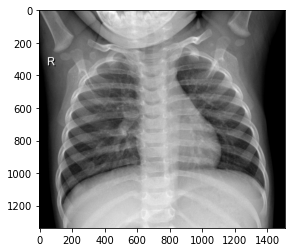

(1337, 1508)


In [9]:
path = os.path.join(train_dir, 'NORMAL') 

for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
    plt.imshow(img_array, cmap='gray')
    plt.show()
    break
print(img_array.shape)   

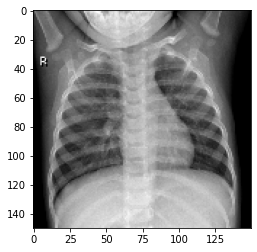

In [10]:
img_size = 150
new_array = cv2.resize(img_array, (img_size, img_size))
plt.imshow(new_array, cmap ='gray')
plt.show()

In [0]:
path = os.path.join(train_dir, 'NORMAL') 

train_data = []

def create_training_data():
  for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
    img_array = cv2.resize(img_array, (img_size, img_size))
    img_array = np.array(img_array).reshape(-1, img_size, img_size, 1)
    img_array = img_array.astype('float32') / 255
    train_data.append(img_array)

create_training_data()

In [12]:
print(len(train_data))

1354


In [0]:
import pickle

pickle_out = open('train.pickle', 'wb')
pickle.dump(train_data, pickle_out)
pickle_out.close()

In [0]:
X = pickle.load(open('train.pickle', 'rb'))
X[1]

In [15]:
print(X[1].shape)
print(len(X))

(1, 150, 150, 1)
1354


In [18]:
print(len(train_data))

1354


## Generating real, fake images and building Discriminator

In [17]:
# import necessary packages
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import rand
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


In [0]:
# defining the hyperparameters
batch_size = 32
epochs = 20
img_height = 150
img_width = 150

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 75, 75, 64)        640       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 75, 75, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 38, 38, 64)        36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 38, 38, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 38, 38, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 92416)            

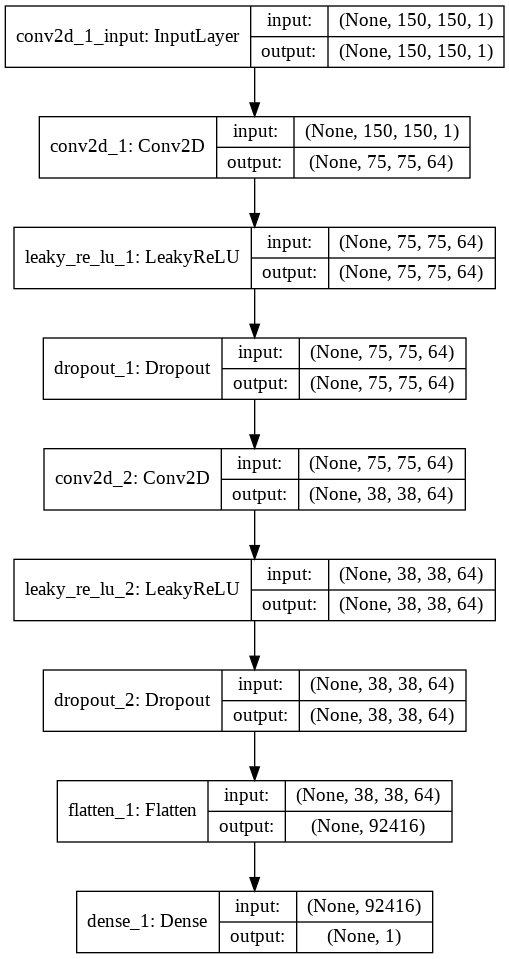

In [20]:
# define the standalone discriminator model
def define_discriminator(in_shape=(150,150,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model
 
# define model
model = define_discriminator()
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, len(dataset) , n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

In [0]:
for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
    img_array = cv2.resize(img_array, (img_size, img_size))
    img_array = np.array(img_array).reshape(-1, img_size, img_size, 1)
    img_array = img_array.astype('float32') / 255

In [0]:
# generate n fake samples with class labels
def generate_fake_samples(n_samples):
	# generate uniform random numbers in [0,1]
	X = rand(img_height * img_width * n_samples)
	# reshape into a batch of grayscale images
	X = X.reshape((n_samples, img_height, img_width, 1))
	# generate 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

In [0]:
# train the discriminator model
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		_, real_acc = model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update discriminator on fake samples
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		# summarize performance
		print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [26]:
# define the discriminator model
model = define_discriminator()
# load image data
dataset = img_array
# fit the model
train_discriminator(model, dataset)

>1 real=76% fake=0%
>2 real=100% fake=1%
>3 real=100% fake=91%
>4 real=100% fake=100%
>5 real=100% fake=100%
>6 real=100% fake=100%
>7 real=100% fake=100%
>8 real=100% fake=100%
>9 real=100% fake=100%
>10 real=100% fake=100%
>11 real=100% fake=100%
>12 real=100% fake=100%
>13 real=100% fake=100%
>14 real=100% fake=100%
>15 real=100% fake=100%
>16 real=100% fake=100%
>17 real=100% fake=100%
>18 real=100% fake=100%
>19 real=100% fake=100%
>20 real=100% fake=100%
>21 real=100% fake=100%
>22 real=100% fake=100%
>23 real=100% fake=100%
>24 real=100% fake=100%
>25 real=100% fake=100%
>26 real=100% fake=100%
>27 real=100% fake=100%
>28 real=100% fake=100%
>29 real=100% fake=100%
>30 real=100% fake=100%
>31 real=100% fake=100%
>32 real=100% fake=100%
>33 real=100% fake=100%
>34 real=100% fake=100%
>35 real=100% fake=100%
>36 real=100% fake=100%
>37 real=100% fake=100%
>38 real=100% fake=100%
>39 real=100% fake=100%
>40 real=100% fake=100%
>41 real=100% fake=100%
>42 real=100% fake=100%
>43 rea

## Building Generator

In [0]:
from numpy import zeros
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from matplotlib import pyplot

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 80000)             8080000   
_________________________________________________________________
leaky_re_lu_35 (LeakyReLU)   (None, 80000)             0         
_________________________________________________________________
reshape_8 (Reshape)          (None, 25, 25, 128)       0         
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 75, 75, 128)       262272    
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 75, 75, 128)       0         
_________________________________________________________________
conv2d_transpose_14 (Conv2DT (None, 150, 150, 128)     262272    
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 150, 150, 128)   

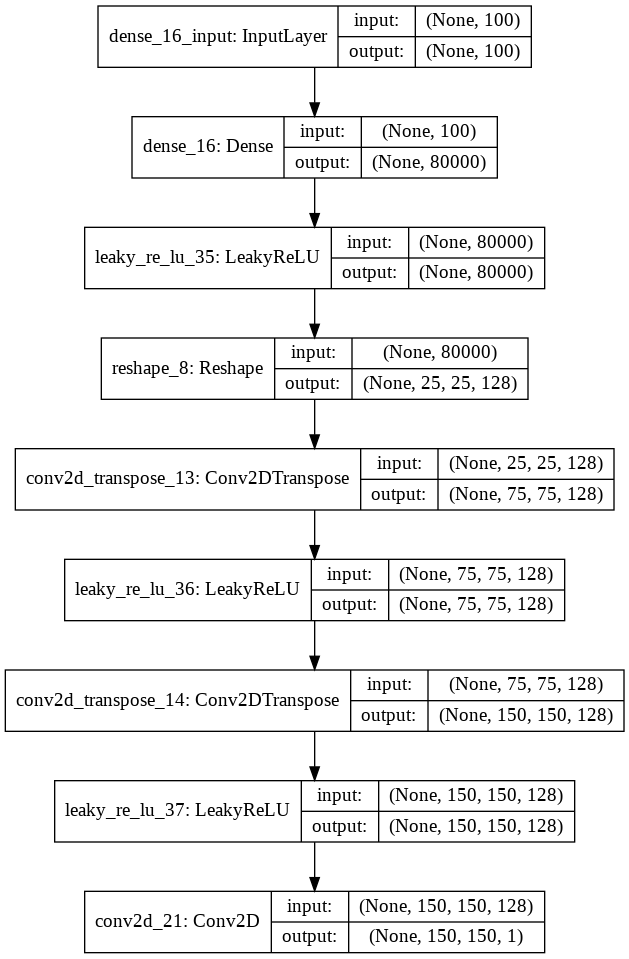

In [61]:
# define the standalone generator model
def define_generator(latent_dim):
  model = Sequential()
  # foundation for 25x25 image
  n_nodes = 128 * 25 * 25
  model.add(Dense(n_nodes, input_dim=latent_dim)) 
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((25, 25, 128)))
    # upsample to 75x75
  model.add(Conv2DTranspose(128, (4,4), strides=(3,3), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 150x150
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) 
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(1, (25,25), activation='sigmoid', padding='same')) 
  return model

# define the size of the latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
   # generate points in the latent space
   x_input = randn(latent_dim * n_samples)
# reshape into a batch of inputs for the network
   x_input = x_input.reshape(n_samples, latent_dim) 
   return x_input

In [0]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
   # generate points in latent space
  x_input = generate_latent_points(latent_dim, n_samples)
  # predict outputs
  X = g_model.predict(x_input)
  # create 'fake' class labels (0) 
  y = zeros((n_samples, 1))
  return X, y

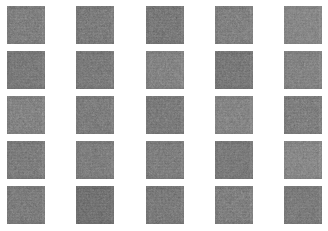

In [64]:
# size of the latent space
latent_dim = 100
# define the discriminator model
model = define_generator(latent_dim)
# generate samples
n_samples = 25
X, _ = generate_fake_samples(model, latent_dim, n_samples)
 # plot the generated samples
for i in range(n_samples):
  # define subplot
  pyplot.subplot(5, 5, 1 + i)
  # turn off axis labels
  pyplot.axis('off')
  # plot single image 
  pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
# show the figure
pyplot.show()

## Train the Generator Model

In [0]:

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
  # make weights in the discriminator not trainable 
  d_model.trainable = False
  # connect them
  model = Sequential()
  # add generator
  model.add(g_model)
  # add the discriminator
  model.add(d_model)

  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_24 (Sequential)   (None, 150, 150, 1)       8684545   
_________________________________________________________________
sequential_23 (Sequential)   (None, 1)                 129985    
Total params: 8,814,530
Trainable params: 8,684,545
Non-trainable params: 129,985
_________________________________________________________________


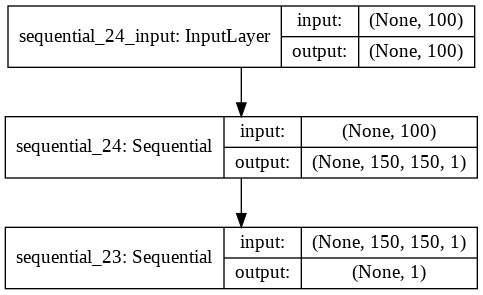

In [67]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()
# plot gan model
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
   # prepare real samples
  X_real, y_real = generate_real_samples(dataset, n_samples)
  # evaluate discriminator on real examples
  _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
  print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100)) # save plot
  save_plot(x_fake, epoch)
  # save the generator model tile file
  filename = 'generator_model_%03d.h5' % (epoch + 1) 
  g_model.save(filename)

In [0]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10): 
  # plot images
  for i in range(n * n):
    # define subplot
    pyplot.subplot(n, n, 1 + i)
    # turn off axis
    pyplot.axis('off')
    # plot raw pixel data
    pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename = 'generated_plot_e%03d.png' % (epoch+1) 
    pyplot.savefig(filename)
    pyplot.close()

In [0]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256): 
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
  # enumerate batches over the training set 
    for j in range(bat_per_epo):
      # get randomly selected 'real' samples
      X_real, y_real = generate_real_samples(dataset, half_batch)
      # generate 'fake' examples
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # create training set for the discriminator
      X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
      # update discriminator model weights
      d_loss, _ = d_model.train_on_batch(X, y)
      # prepare points in latent space as input for the generator
      X_gan = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      # summarize loss on this batch
      print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
  # evaluate the model performance, sometimes
  if (i+1) % 10 == 0:
    summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [71]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = img_array
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

>Accuracy real: 100%, fake: 100%


## Use the Final Generator Model

In [0]:
# example of loading the generator model and generating images
from keras.models import load_model 
from numpy.random import randn
from matplotlib import pyplot
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples): 
  # generate points in the latent space
  x_input = randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network 
  x_input = x_input.reshape(n_samples, latent_dim) 
  return x_input

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


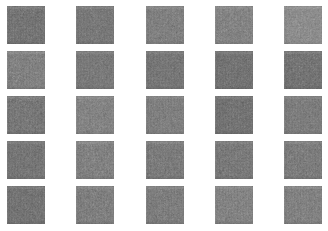

In [74]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, n): 
  # plot images
  for i in range(n * n):
    # define subplot
    pyplot.subplot(n, n, 1 + i)
    # turn off axis
    pyplot.axis('off')
    # plot raw pixel data
    pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
  pyplot.show()
# load model
model = load_model('generator_model_100.h5')
# generate images
latent_points = generate_latent_points(100, 25) # generate images
X = model.predict(latent_points)
# plot the result
save_plot(X, 5)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


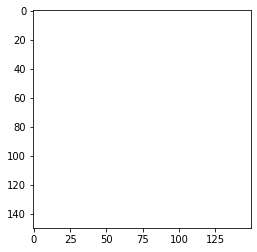

In [77]:
# example of generating an image for a specific point in the latent space
from keras.models import load_model 
from numpy import asarray
from matplotlib import pyplot
# load model
model = load_model('generator_model_100.h5') 
# all 0s
vector = asarray([[0.0 for _ in range(100)]]) 
# generate image
X = model.predict(vector)
# plot the result
pyplot.imshow(X[0, :, :, 0], cmap='gray_r') 
pyplot.show()